In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import timedelta

sns.set_theme(style='ticks', context='paper')

In [2]:
with open("data/gb_ci.csv", "r") as csvfile:
    gb = pd.read_csv(csvfile, index_col=0, parse_dates=True)["Carbon Intensity"].rename("Great Britain")
with open("data/ger_ci.csv", "r") as csvfile:
    ger = pd.read_csv(csvfile, index_col=0, parse_dates=True)["Carbon Intensity"].rename("Germany")
with open("data/cal_ci.csv", "r") as csvfile:
    cal = pd.read_csv(csvfile, index_col=0, parse_dates=True)["Carbon Intensity"].rename("California")
with open("data/fr_ci.csv", "r") as csvfile:
    fr = pd.read_csv(csvfile, index_col=0, parse_dates=True)["Carbon Intensity"].rename("France")
ger = ger["2020-01-01 00:00:00":"2021-01-01 00:00:00"]
gb = gb["2020-01-01 00:00:00":"2021-01-01 00:00:00"]
cal = cal["2020-01-01 00:00:00":"2021-01-01 00:00:00"]
fr = fr["2020-01-01 00:00:00":"2021-01-01 00:00:00"]

MEASUREMENT_INTERVAL = 30
ger = ger[ger.index.minute % MEASUREMENT_INTERVAL == 0]
gb = gb[gb.index.minute % MEASUREMENT_INTERVAL == 0]
cal = cal[cal.index.minute % MEASUREMENT_INTERVAL == 0]
fr = fr[fr.index.minute % MEASUREMENT_INTERVAL == 0]

full = pd.concat([ger, cal, gb, fr], axis=1)
full

,Germany,California,Great Britain,France
Time,,,,
2020-01-01 00:00:00,353.319875,342.092256,192.229224,56.033471
2020-01-01 00:30:00,351.252335,347.220539,194.251856,52.740640
2020-01-01 01:00:00,349.628409,344.967632,195.211861,48.375163
2020-01-01 01:30:00,346.373119,339.952418,190.238991,43.531716
2020-01-01 02:00:00,347.674818,336.563101,186.122673,40.306003
...,...,...,...,...
2020-12-31 22:00:00,426.575116,376.835143,251.141608,69.073480
2020-12-31 22:30:00,426.077061,374.563315,243.237501,68.195328
2020-12-31 23:00:00,427.580284,371.903162,233.778838,65.697676


# Overview

In [3]:
full.describe()

,Germany,California,Great Britain,France
count,17569.000000,17569.000000,17569.000000,17569.000000
mean,313.396106,279.706220,212.942491,56.336777
std,110.454244,72.856504,65.291795,19.102152
min,100.657858,53.934563,63.689930,19.494886
25%,222.764276,230.823460,160.105196,41.593088
50%,312.549830,291.916133,210.428638,57.423619
75%,389.590156,338.124076,259.942319,69.287476
max,593.142244,427.009412,394.860422,116.394154


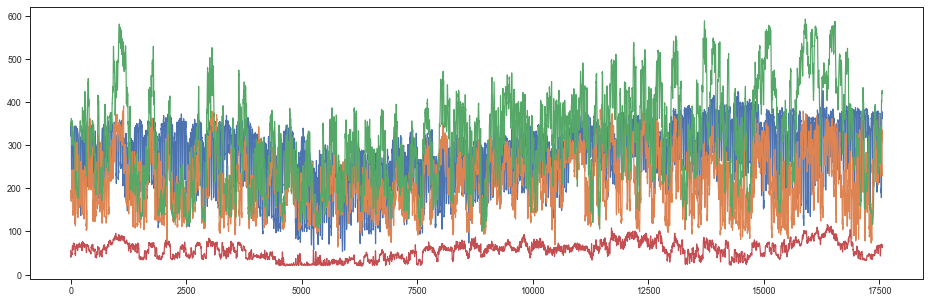

In [4]:
# Time Series Overview
plt.figure(figsize=(16, 5))
plt.plot(range(len(cal.index)), cal.values)
plt.plot(range(len(gb.index)), gb.values)
plt.plot(range(len(ger.index)), ger.values)
plt.plot(range(len(fr.index)), fr.values)
plt.show()

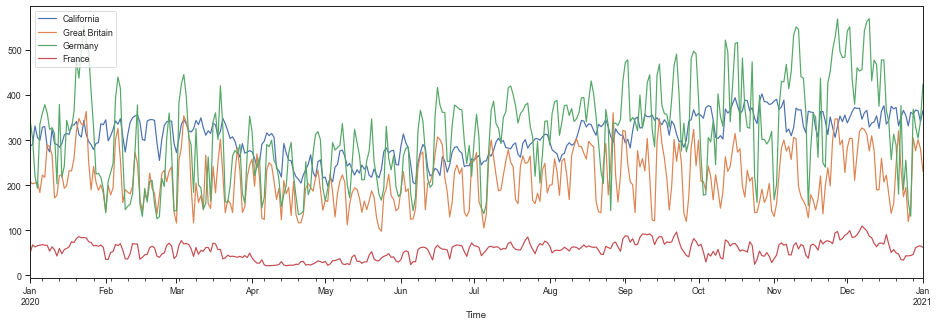

In [5]:
# Time Series Overview Smoothed
plt.figure(figsize=(16, 5))
cal.groupby(pd.Grouper(freq='1D')).median().plot()
gb.groupby(pd.Grouper(freq='1D')).median().plot()
ger.groupby(pd.Grouper(freq='1D')).median().plot()
fr.groupby(pd.Grouper(freq='1D')).median().plot()
plt.legend(title='', loc='upper left')
plt.show()

# Histograms

([<matplotlib.lines.Line2D object at 0x7ff95dde97c0>, <matplotlib.lines.Line2D object at 0x7ff95ddc0490>, <matplotlib.lines.Line2D object at 0x7ff95d774400>, <matplotlib.lines.Line2D object at 0x7ff95debf310>], ['Germany', 'California', 'Great Britain', 'France'])


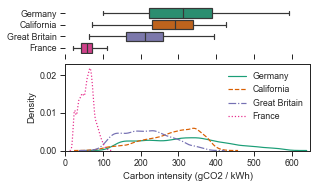

In [6]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.35, .65)}, figsize=(4.5,2.7))

sns.boxplot(data=full, orient="h", fliersize=0, ax=ax_box, palette=["#1b9e77", "#d95f02", "#7570b3", "#e7298a"])
x = sns.kdeplot(data=ger, ax=ax_hist, color="#1b9e77", linestyle='solid', label='Germany')
x = sns.kdeplot(data=cal, ax=ax_hist, color="#d95f02", linestyle='dashed', label='California')
x = sns.kdeplot(data=gb, ax=ax_hist, color="#7570b3", linestyle='dashdot', label='Great Britain')
x = sns.kdeplot(data=fr, ax=ax_hist, color="#e7298a", linestyle='dotted', label='France')

sns.despine(ax=ax_box, left=True, bottom=True)
f.tight_layout()
ax_hist.set(xlabel='Carbon intensity (gCO2 / kWh)')

ax_hist.set_xlim(0, 650)

print(ax_hist.get_legend_handles_labels())
#legend = ax_hist.get_legend()
#legend.set_frame_on(False)
ax_hist.legend(frameon=False)


plt.savefig("img/hist.pdf", dpi=300, bbox_inches='tight')

# Best Time of Day Plot

In [7]:
def best_time_of_day_heatmap(df, ax, hours_lookahead, plus=True, printdf=False):
    highest_diff = None

    steps_lookahead = hours_lookahead * 2
    for i in range(1, steps_lookahead + 1):
        roll_i = -i if plus else i
        value_at_lookahead = np.roll(df.values, roll_i)
        diff_at_lookahead = ((df - value_at_lookahead))["2020-01-01 00:00:00":"2021-01-01 00:00:00"]
        if highest_diff is None:
            highest_diff = diff_at_lookahead
        else:
            highest_diff = pd.concat([highest_diff, diff_at_lookahead], axis=1).max(axis=1)
    
    groupby = highest_diff.groupby([highest_diff.index.hour, highest_diff.index.minute])
    series = []
    for threshold in [120, 100, 80, 60, 40, 20]:
        series.append(groupby.agg(lambda x: (x > threshold).sum()).rename(threshold))
    df = pd.concat(series, axis=1) / 3.66
    df.loc[(24,0),:] = df.loc[0,0]  # adding first column to end for complete "cyclic" plots
    colormap = "rocket" if plus else "mako"
    
    if printdf:
        print(df)
    
    # Dirty way to avoid weird Matplotlib "stacked" styling
    df.loc[:,100] = df.loc[:,100] - df.loc[:,120]
    df.loc[:,80] = df.loc[:,80] - df.loc[:,120] - df.loc[:,100]
    df.loc[:,60] = df.loc[:,60] - df.loc[:,120] - df.loc[:,100] - df.loc[:,80]
    df.loc[:,40] = df.loc[:,40] - df.loc[:,120] - df.loc[:,100] - df.loc[:,80] - df.loc[:,60]
    df.loc[:,20] = df.loc[:,20] - df.loc[:,120] - df.loc[:,100] - df.loc[:,80] - df.loc[:,60] - df.loc[:,40]

    df.plot.area(colormap=sns.color_palette(colormap, as_cmap=True), ax=ax)
    
    ax.set_xlim(0, 48)
    ax.set_ylim(0, 100)

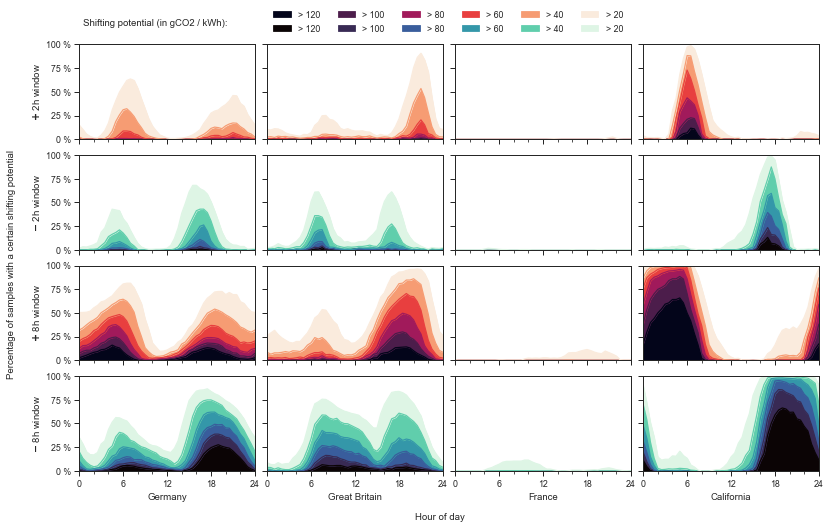

In [8]:
# Comparing Forecast Windows

f, axs = plt.subplots(ncols=4, nrows=4, sharey=True, sharex=True, figsize=(11,6.5))
f.tight_layout(h_pad=0.7, w_pad=0)
countries = iter([ger, gb, fr, cal])
for row, lookahead, plus in zip(axs, [2, 2, 8, 8], [True, False, True, False]):
    for ax, country in zip(row, [ger, gb, fr, cal]):
        best_time_of_day_heatmap(country, ax, hours_lookahead=lookahead, plus=plus)
        ax.get_legend().remove()
        ax.set_ylabel(r"$\bf{" + ('+' if plus else '-') + "}$" + f" {lookahead}h window")
        ax.set_xlabel(country.name)
        ticks = range(0, 48+1, 12)
        ax.set_xticks(ticks)
        ax.set_xticks(range(0, 48, 4), minor=True)
        ax.set_xticklabels([f"{h/2:.0f}" for h in ticks])
        
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticks([], minor=True)
        ax.set_yticklabels(["0 %", "25 %", "50 %", "75 %", "100 %"])
        
    # Store both axes types in variables for correct legend plotting
    if plus:
        red_ax = ax
    else:
        blue_ax = ax
        
f.text(0.05, 1.015, "Shifting potential (in gCO2 / kWh):", ha="left", va="center")
handles, labels = red_ax.get_legend_handles_labels()
f.legend(handles, ["> 120", "> 100", "> 80", "> 60", "> 40", "> 20"], loc='upper left', bbox_to_anchor=(0.28, 1.06), frameon=False, ncol=len(labels))
handles, labels = blue_ax.get_legend_handles_labels()
f.legend(handles, ["> 120", "> 100", "> 80", "> 60", "> 40", "> 20"], loc='upper left', bbox_to_anchor=(0.28, 1.03), frameon=False, ncol=len(labels))


f.text(0.5, -0.04, "Hour of day", ha="center", va="center")
f.text(-0.04, 0.5, "Percentage of samples with a certain shifting potential", ha="center", va="center", rotation="vertical")

plt.savefig("img/daily_analysis.pdf", dpi=300, bbox_inches='tight')

Text(-0.04, 0.5, 'Shifting potential at different forecast windows')

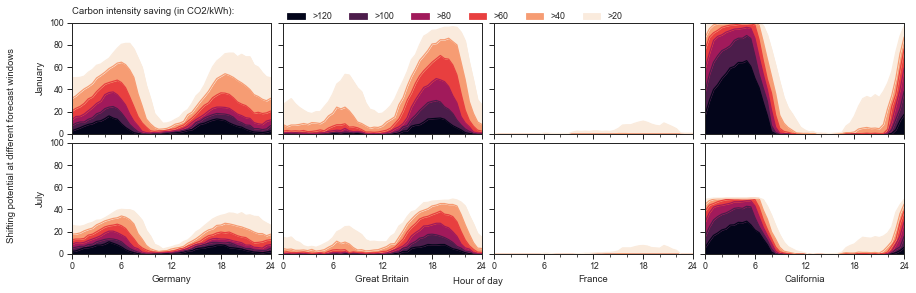

In [9]:
# Comparing Januray to July

f, axs = plt.subplots(ncols=4, nrows=2, sharey=True, sharex=True, figsize=(12,3.5))
f.tight_layout(pad=0)
countries = iter([ger, gb, fr, cal])
for row, (month, start, stop) in zip(axs, [("January", "2020-01-01 00:00:00","2021-02-01 00:00:00"), ("July", "2020-07-01 00:00:00","2021-08-01 00:00:00")]):
    for ax, country in zip(row, [ger, gb, fr, cal]):
        best_time_of_day_heatmap(country[start:stop], ax, hours_lookahead=8)
        ax.get_legend().remove()
        ax.set_ylabel(month)
        ax.set_xlabel(country.name)
        ticks = range(0, 48+1, 12)
        ax.set_xticks(ticks)
        ax.set_xticks(range(0, 48, 4), minor=True)
        ax.set_xticklabels([f"{h/2:.0f}" for h in ticks])

handles, labels = ax.get_legend_handles_labels()
f.text(0.03, 1.03, "Carbon intensity saving (in CO2/kWh):", ha="left", va="center")
f.legend(handles, [">120", ">100", ">80", ">60", ">40", ">20"], loc='upper left', bbox_to_anchor=(0.27, 1.06), frameon=False, ncol=len(labels))

f.text(0.5, -0.04, "Hour of day", ha="center", va="center")
f.text(-0.04, 0.5, "Shifting potential at different forecast windows", ha="center", va="center", rotation="vertical")

# Saisonal Analysis

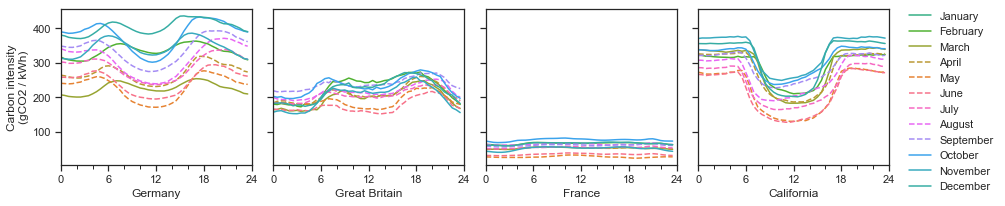

In [10]:
sns.set_theme(style='ticks')

f, axs = plt.subplots(ncols=4, nrows=1, sharey=True, sharex=True, figsize=(12,2.5))
f.tight_layout(pad=0)

palette = sns.palettes._ColorPalette(np.roll(np.flip(sns.color_palette("husl", 12), axis=0), 6, axis=0))

for ax, s, country in zip(axs, [ger, gb, fr, cal], ["Germany", "Great Britain", "France", "California"]):
    x = pd.DataFrame(s)
    
    for month, color, linestyle in zip(range(12), palette, ["-","-","-","--","--","--","--","--","--","-","-","-"]):
        xm = x[x.index.month == month]
        xm = xm.groupby(xm.index.hour * 60 + xm.index.minute).mean()
        ax.plot(xm.index, xm[country], color=color, linestyle=linestyle, label=month)

    ax.set(xlabel=country)
    ax.set_xlim(0, 1440)
    ticks = range(0, 24*60+1, 60*6)
    minior_ticks = range(0, 24*60+1, 60*2)
    ax.set_xticks(ticks)
    ax.set_xticks(minior_ticks, minor=True)
    ax.set_xticklabels([f"{int(tick/60)}" for tick in ticks])

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], loc='upper right', bbox_to_anchor=(1.12, 1.02), frameon=False)

axs[0].set(ylabel='Carbon intensity\n(gCO2 / kWh)')
plt.savefig("img/seasons.pdf", dpi=300, bbox_inches='tight')

# Weekly Analysis

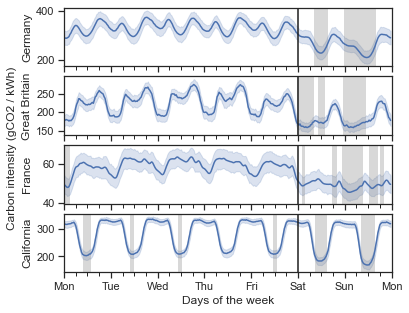

In [11]:
f, axs = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(5,4))
f.tight_layout(pad=0)
f.text(-0.075, 0.5, "Carbon intensity (gCO2 / kWh)", ha="center", va="center", rotation="vertical")

steps = 2 * 24
for df, ax in zip([ger, gb, fr, cal], axs):
    x = pd.DataFrame(df)
    x["time"] = df.index.day_of_week * 24 * 60 + df.index.hour * 60 + df.index.minute
    sns.lineplot(data=x, x="time", y=df.name, ci=95, ax=ax)
    ax.set_xlim(0, 1440 * 7)
    
    ax.axvline(1440*5, color="k")

    start = None
    end = None
    for idx, _ in sorted(x.groupby("time").mean().sort_values(df.name)[:steps].iterrows()):
        if start is None:
            start = idx
            end = idx+30
        elif idx == end:
            end = idx+30
        else:
            ax.axvspan(start, end, facecolor="0.5", alpha=0.3, lw=0)
            start = idx
            end = idx+30
    ax.axvspan(start, end, facecolor="0.5", alpha=0.3, lw=0)
    
    ticks = range(0, 7*24*60+1, 24*60)
    ax.set_xticks(ticks)
    ax.set_xticks(range(0, 7*24*60+1, 6*60), minor=True)
    ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax.set(xlabel="Days of the week")
f.align_ylabels()

plt.savefig("img/week.pdf", dpi=300, bbox_inches='tight')

In [12]:
# Computing CI difference of workdays and weekend
for df in [ger, gb, fr, cal]:
    x = pd.DataFrame(df)
    x.index = pd.Index(df.index.day_of_week * 24 * 60 + df.index.hour * 60 + df.index.minute)
    x = x.groupby(x.index).median()
    workdays = x[:5*24*2]
    weekend = x[5*24*2:]
    print(df.name)
    print(workdays.mean().values)
    print(weekend.mean().values)
    print(f"{(1 - weekend.mean() / workdays.mean()).values[0]:.2%}")
    print()


Germany
[330.78029036]
[246.69745982]
25.42%

Great Britain
[222.64568388]
[172.15334183]
22.68%

France
[60.91000694]
[47.42044097]
22.15%

California
[289.73837365]
[271.76911269]
6.20%

